# First Spark Streaming Example
_____

In [1]:
import findspark

findspark.init('/Users/neerajpadarthi/Neeraj/spark-2.3.0-bin-hadoop2.7')

# May cause deprecation warnings, safe to ignore, they aren't errors
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc
from pyspark.sql import Row
import re

# Can only run this once. restart your kernel for any errors.
sc = SparkContext.getOrCreate()
# sc1 = SparkSession.builder.appName("Hive TST").enableHiveSupport().getOrCreate()



ssc = StreamingContext(sc, 10 )
sqlContext = SQLContext(sc)

socket_stream = ssc.socketTextStream("127.0.0.1", 5551)

lines = socket_stream.window( 20,20 )

from collections import namedtuple
fields = ("tag", "count" )
Tweet = namedtuple( 'Tweet', fields )

fields = ("tweet" )
Tweet1 = namedtuple( 'Tweet', fields )

# Use Parenthesis for multiple lines or use \.
( lines.flatMap( lambda text: text.split( " " ) ) 
  .filter( lambda word: word.lower().startswith("#") ) 
  .map( lambda word: ( word.lower(), 1 ) ) 
  .reduceByKey( lambda a, b: a + b ) 
  .map( lambda rec: Tweet( rec[0], rec[1] ) ) 
  .foreachRDD( lambda rdd: rdd.toDF().sort( desc("count") ) 
  .limit(10).registerTempTable("tweets") ) ) 




lines.map(lambda x: (x.replace(',','').lower(), )).foreachRDD( lambda rdd: rdd.toDF().registerTempTable("tweets1") )

def Find(string): 
    # findall() has been used  
    # with valid conditions for urls in string 
    return (re.search("(?P<url>https?://[^\s]+)", string))

lines.flatMap(lambda text: text.split(" "))\
.filter( lambda word: word.startswith("http")).map( lambda word: ( word.lower(), 1 ) )\
.reduceByKey( lambda a, b: a + b ).foreachRDD( lambda rdd: rdd.toDF()\
  .limit(10).registerTempTable("tweets_url") )




# lines.pprint()

__________
### Run the TweetRead.py file at this point
__________

In [2]:
import time
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas
# Only works for Jupyter Notebooks!
%matplotlib inline 

ssc.start()

In [ ]:
# from pyspark.sql import SparkSession, column
# spark = SparkSession.builder.appName("Hive TST").enableHiveSupport().getOrCreate()

# spark.sql("use default").show()
# spark.sql("CREATE TABLE tweets_tbl(text string)").show()
# spark.sql("INSERT INTO table tweets_tbl SELECT * FROM tweets").show()

In [3]:
count = 0
while count < 20:
    time.sleep(20)
    sqlContext.sql( 'Select * from tweets1').coalesce(1).write.mode("append").option("header",True).format("csv").save("temp_csv")
    count = count + 1

ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


In [8]:
import re,pandas as pd
from joblib import dump,load
from textblob import TextBlob


model=load('lr.joblib')
tfidf_temp=load('tfid.joblib')


def data_cleansing(corpus):
    letters_only = re.sub("[^a-zA-Z]", " ", corpus) 
    words = letters_only.lower().split()                            
    return( " ".join( words ))

def model_predict(text):
    t_a=tfidf_temp.transform(pd.Series(text).astype(str))
    pred1 = model.predict(t_a)
    print(pred1)
    return (pred1[0])

def model_textblob(text):
    score=TextBlob(str((text).encode('ascii', 'ignore'))).sentiment.polarity
    if score <= 0.0 :
        return ('negative')
    else:
        return ('positive')

from pyspark.sql.types import StringType
spark.udf.register("custom_udf", data_cleansing, StringType())
spark.udf.register("custom_predict",model_predict,StringType())
spark.udf.register("texblob",model_textblob,StringType())

<function __main__.model_textblob(text)>

In [9]:
spark.sql("SELECT _1,custom_predict(custom_udf(_1)),texblob(custom_udf(_1)) FROM tweets1").show()

+--------------------+------------------------------+-----------------------+
|                  _1|custom_predict(custom_udf(_1))|texblob(custom_udf(_1))|
+--------------------+------------------------------+-----------------------+
|just follow @fand...|                      positive|               negative|
|                    |                      negative|               negative|
|« mané pas sur le...|                      negative|               negative|
|                    |                      negative|               negative|
|dé…mini wireless ...|                      negative|               positive|
|get this deal tod...|                      positive|               positive|
|                    |                      negative|               negative|
|✅ consecutive 90+...|                      positive|               positive|
|✅ top prospect in...|                      negative|               positive|
|✅ top farm system...|                      positive|           

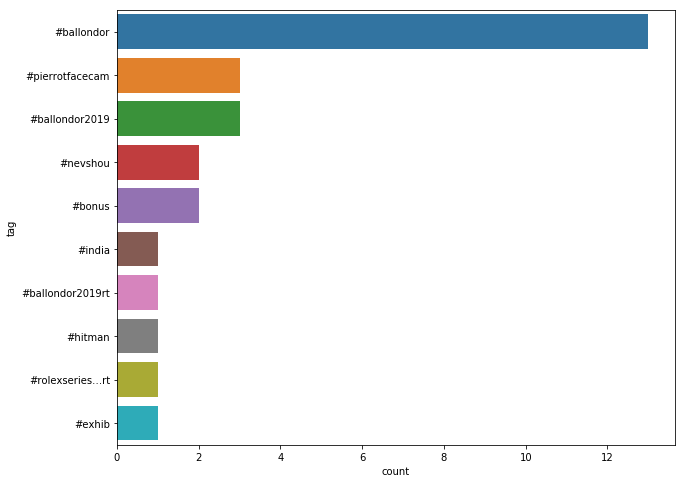

In [3]:
count = 0
while count < 10:
    time.sleep(5)
    top_10_tweets = sqlContext.sql( 'Select tag, count from tweets' )
    top_10_df = top_10_tweets.toPandas()
    display.clear_output(wait=True)
    plt.figure( figsize = ( 10, 8 ) )
    sns.barplot( x="count", y="tag", data=top_10_df)
    plt.show()
    count = count + 1

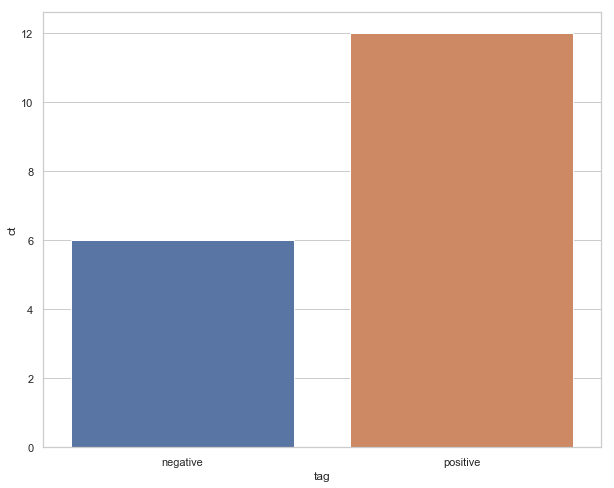

In [4]:
count = 0
while count < 10:
    
    time.sleep( 5 )
    df=sqlContext.sql( "Select 'negative' tag,count(distinct _1) ct from tweets1 WHERE (_1 LIKE '%disappoi%' or _1 LIKE '%sad%' or _1 LIKE '%concern%' or _1 LIKE '%bad%' or _1 LIKE '%fail%') \
               UNION \
               Select 'positive' tag,count(distinct _1) ct from tweets1 WHERE (_1 LIKE '%happy%' OR _1 LIKE '%wonderful%' OR _1 LIKE '%bliss%' OR _1 LIKE '%hope%' OR _1 LIKE '%win%')").toPandas()
    display.clear_output(wait=True)
    plt.figure( figsize = ( 10, 8 ) )
    sns.set(style="whitegrid")
    sns.barplot( x="tag", y="ct", data=df)
    plt.show()
    count = count + 1

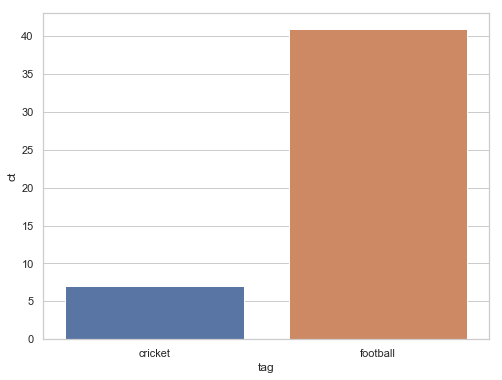

In [5]:
count = 0
while count < 10:
    
    time.sleep(3)
    df=sqlContext.sql( "Select 'cricket' tag,count(distinct _1) ct from tweets1 WHERE (_1 LIKE '%cricket%' or _1 LIKE '%cric%') \
               UNION \
               Select 'football' tag,count(distinct _1) ct from tweets1 WHERE (_1 LIKE '%football%')").toPandas()
    display.clear_output(wait=True)
    plt.figure( figsize = ( 8, 6 ) )
    sns.set(style="whitegrid")
    sns.barplot( x="tag", y="ct", data=df)
    plt.show()
    count = count + 1

In [6]:
count = 0
while count < 10:
    time.sleep(5)
    sqlContext.sql( 'Select _1 url,_2 ct from tweets_url').show(truncate=False)
    display.clear_output(wait=True)
    count = count + 1

+--------------------------------------+---+
|url                                   |ct |
+--------------------------------------+---+
|https://t.co/hpffnwlnolrt             |1  |
|https://t.co/1uq2v2jxwkrod            |1  |
|https://t.co/dg0xi…rt                 |1  |
|https://t.co/veipxe2a2nrt             |1  |
|https://t.co/p6p5nd0yuz@suhasspai     |1  |
|https://t.co/sja1e3idsmcongratulations|1  |
|https://t.co/ur55lk1yqythis           |1  |
|https://t.co/vgzufegyuwour            |1  |
|https://t.co/xujpzw7xrw               |1  |
|https://t.co/ifqgvvxjgsмесси          |1  |
+--------------------------------------+---+



In [10]:
ssc.stop()